In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import archetypes as arch
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import pearsonr
import sklearn.metrics as metrics
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, leaves_list
from pysal.lib import weights
import geopandas as gpd
from shapely.geometry import Point
from pysal.explore import esda
from scipy.spatial.distance import jensenshannon

/home/demeter_turos/anaconda3/envs/BearCovid/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.h

In [2]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

plt.rcParams['svg.fonttype'] = 'none'
data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/cell2loc_human_lymph_node/'

In [ ]:
# run chrysalis
# calculate SVGs

adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=6000)
sc.pp.filter_genes(adata, min_cells=10)

sc.pl.spatial(adata, img_key="hires", color="total_counts", size=1.8, cmap='viridis')

chrysalis_svg(adata, min_morans=0.05, min_spots=0.05)
adata.write(data_path + 'chr.h5ad')

In [4]:
# read back file and proceed with the analysis
adata = sc.read_h5ad(data_path + 'chr.h5ad')
moran_df = adata.var[adata.var["Moran's I"] > 0.08]

adata.var['spatially_variable'] = [True if x in moran_df.index else False for x in adata.var_names]

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)
ch.aa(adata, n_pcs=20, n_archetypes=8)

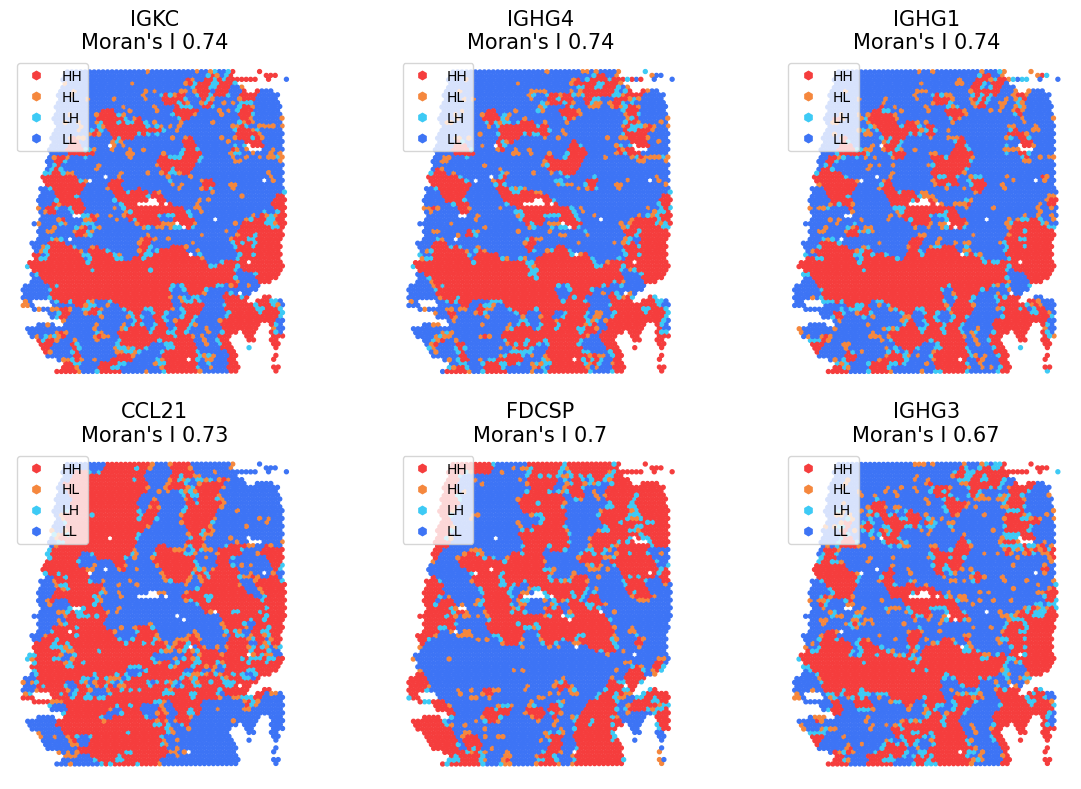

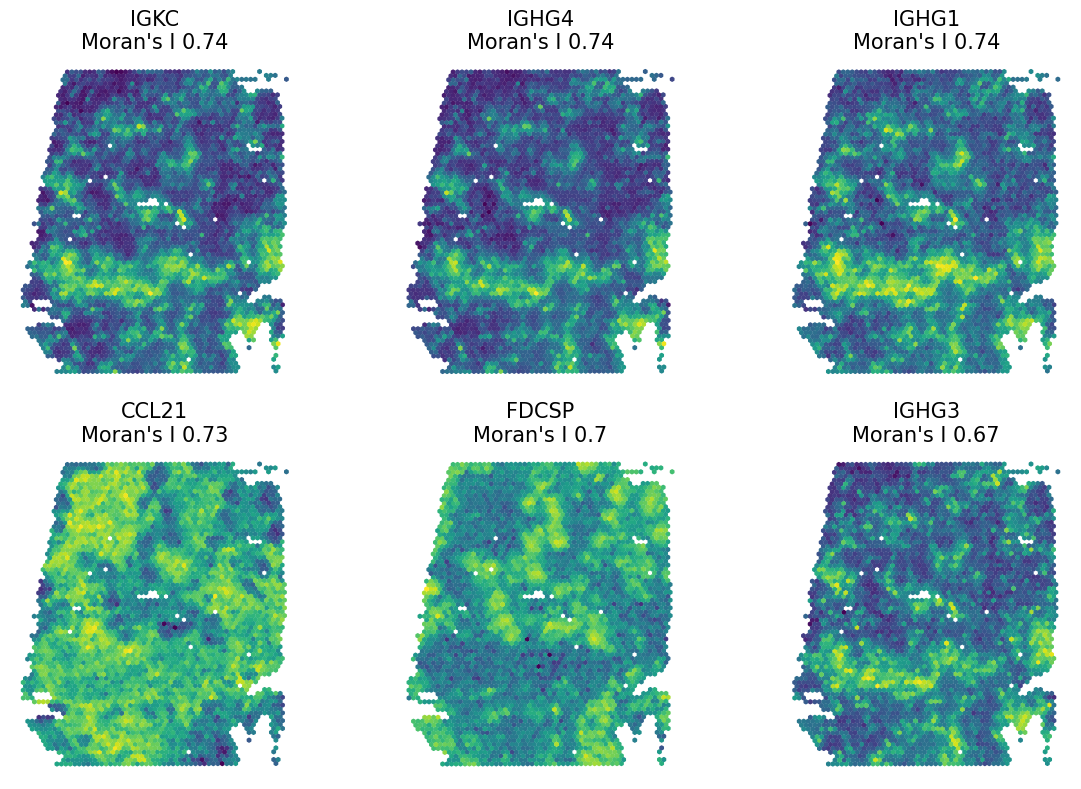

In [5]:
def morans(adata, label):
    gdf = gpd.GeoDataFrame(data={'spots': [Point(x, y) for x, y in zip(adata.obsm['spatial'][:, 0],
                                                                        adata.obsm['spatial'][:, 1]  * -1)]},
                           index=adata.obs_names)
    gdf.geometry = gdf['spots']
    gdf[label] = adata.to_df()[label]
    w = weights.KNN.from_dataframe(gdf, k=6)
    w.transform = 'R'
    gdf[f'{label}_lag'] = weights.spatial_lag.lag_spatial(w, gdf[label])
    gdf[f'{label}_std'] = gdf[label] - gdf[label].mean()
    gdf[f'{label}_lag_std'] = (gdf[f'{label}_lag'] - gdf[f'{label}_lag'].mean())

    lisa = esda.moran.Moran_Local(list(gdf[label]), w, transformation="r", permutations=99)
    hl = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
    gdf['lisa_Is'] = lisa.Is
    gdf['lisa_q'] = lisa.q
    gdf['lisa_q'] = [hl[x] for x in gdf['lisa_q']]
    gdf['lisa_q'] = gdf['lisa_q'].astype('category')
    return gdf


def morans_spatial_plot(gdf, title=None, ax=None, markersize=10):
    cmap = mpl.colors.ListedColormap(('#f53d3d',
                                      '#f5873d',
                                      '#3dcaf5',
                                      '#3d74f5',
                                      ))
    if ax is not None:
        gdf.plot(markersize=markersize, column='lisa_q', cmap=cmap, ax=ax, rasterized=True)
        color_id = {k: v for k, v in zip(gdf['lisa_q'].cat.categories, cmap.colors)}
        markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='h', linestyle='') for color in color_id.values()]
        ax.legend(markers, color_id.keys(), numpoints=1)
        if title:
            ax.set_title(title)
    else:
        fig, axs = plt.subplots(1, 1, figsize=(6, 6))
        gdf.plot(markersize=markersize, column='lisa_q', cmap=cmap, ax=axs, rasterized=True)
        color_id = {k: v for k, v in zip(gdf['lisa_q'].cat.categories, cmap.colors)}
        markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='h', linestyle='') for color in color_id.values()]
        plt.legend(markers, color_id.keys(), numpoints=1)
        axs.axis('off')
        if title:
            plt.title(title)


def morans_scatter(gdf, label, ax=None):
    w = weights.KNN.from_dataframe(gdf, k=6)
    w.transform = 'R'
    moran = esda.moran.Moran(gdf[label], w)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.regplot(x=f'{label}_std', y=f'{label}_lag_std', ci=None, data=gdf, line_kws={'color': 'r'},
                scatter_kws={'alpha': 0.1, 'marker': '.', 's': 5, 'color': 'grey'}, ax=ax)
    ax.axvline(0, c='k', alpha=0.5)
    ax.axhline(0, c='k', alpha=0.5)
    ax.set_aspect('equal')
    ax.set_title(f"Moran Plot - Moran's I {round(moran.I, ndigits=3)} p value: {round(moran.p_sim, ndigits=4)}")
    plt.show()


morans_i = adata.var["Moran's I"].sort_values(ascending=False)
morans_i = morans_i.dropna()

# top Moran's
top_morans_i = morans_i[:6]
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 4 * 2))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
i = 0
for idx, v in top_morans_i.iteritems():
    gdf = morans(adata, idx)
    morans_spatial_plot(gdf, ax=axs[i], markersize=8)
    axs[i].set_title(f"{idx}\nMoran's I {round(v, 2)}", size=15)
    i += 1
plt.tight_layout()
plt.show()

top_morans_i = morans_i[:6]
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 4 * 2))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
i = 0
for idx, v in top_morans_i.iteritems():
    gdf = morans(adata, idx)
    gdf.plot(markersize=8, column=idx, cmap='viridis', ax=axs[i], marker='h', rasterized=True)
    axs[i].set_title(f"{idx}\nMoran's I {round(v, 2)}", size=15)
    i += 1
plt.tight_layout()
plt.show()

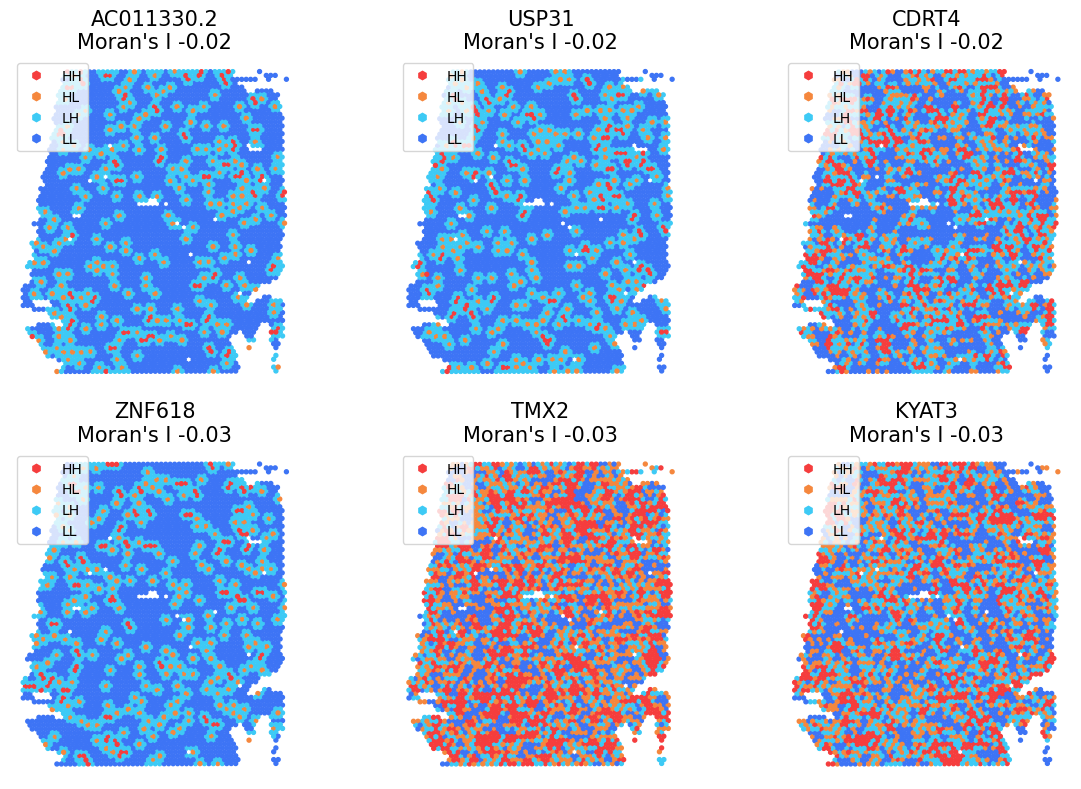

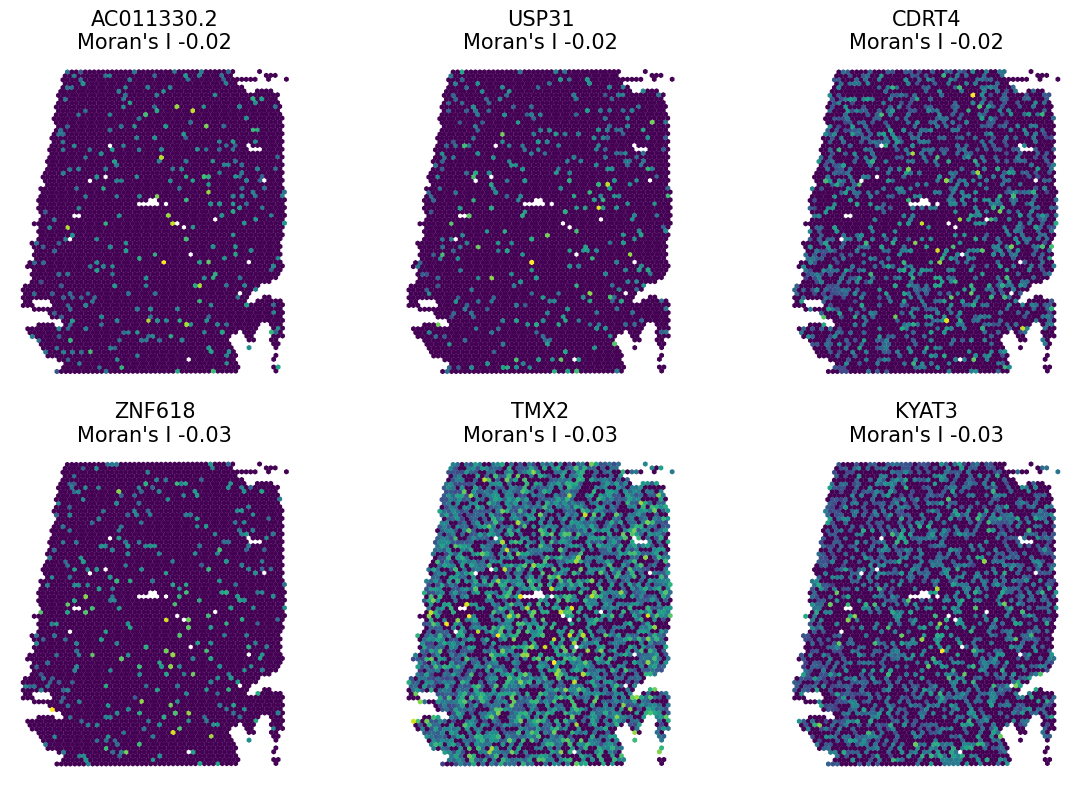

In [6]:
# bottom Moran's
bottom_morans_i = morans_i[-6:]
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 4 * 2))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
i = 0
for idx, v in bottom_morans_i.iteritems():
    gdf = morans(adata, idx)
    morans_spatial_plot(gdf, ax=axs[i], markersize=8)
    axs[i].set_title(f"{idx}\nMoran's I {round(v, 2)}", size=15)
    i += 1
plt.tight_layout()
plt.show()

bottom_morans_i = morans_i[-6:]
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 4 * 2))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
i = 0
for idx, v in bottom_morans_i.iteritems():
    gdf = morans(adata, idx)
    gdf.plot(markersize=8, column=idx, cmap='viridis', ax=axs[i], marker='h', rasterized=True)
    axs[i].set_title(f"{idx}\nMoran's I {round(v, 2)}", size=15)
    i += 1
plt.tight_layout()
plt.show()

In [ ]:
# Moran's I with different neighborhoods

raw_adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

nh_df = pd.DataFrame()
for nh in [6, 18, 36]:
    ad = sc.pp.filter_genes(raw_adata, min_cells=1, copy=True)
    ad.var_names_make_unique()  # moran dies so need some check later
    if "log1p" not in raw_adata.uns_keys():
        sc.pp.normalize_total(ad, inplace=True)
        sc.pp.log1p(ad)

    gene_matrix = ad.to_df()

    points = raw_adata.obsm['spatial'].copy()
    points[:, 1] = points[:, 1] * -1

    w = weights.KNN.from_array(points, k=nh)
    w.transform = 'R'
    moran_dict = {}

    for c in tqdm(ad.var_names, desc='Calculating SVGs'):
        moran = esda.moran.Moran(gene_matrix[c], w, permutations=0)
        moran_dict[c] = moran.I

    moran_df = pd.DataFrame(data=moran_dict.values(), index=moran_dict.keys(), columns=["Moran's I"])
    nh_df[f'KNN {nh}'] = moran_df["Moran's I"]
nh_df.to_csv(data_path + 'morans_knn.csv')

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

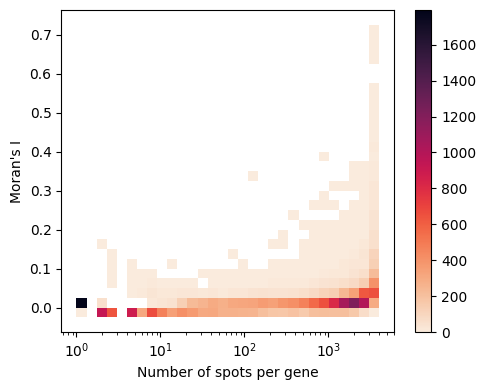

In [7]:
#%%
# read Moran df and plot

nh_df = pd.read_csv(data_path + 'morans_knn.csv', index_col=0)

raw_adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(raw_adata, inplace=True)
ad = sc.pp.filter_genes(raw_adata, min_cells=1, copy=True)
ad.var_names_make_unique()
nh_df['n_cells_by_counts'] = ad.var['n_cells_by_counts']
nh_df['log1p_total_counts'] = ad.var['log1p_total_counts']
nh_df.to_csv(data_path + 'morans_knn.csv')

nh_df_sorted = nh_df.sort_values(ascending=False, by='KNN 6')

fig, ax = plt.subplots(1, 1, figsize=(5 , 4))
sns.histplot(nh_df, x='n_cells_by_counts', y='KNN 6', ax=ax, cmap='rocket_r', log_scale=(True, False),
             bins=30, cbar=True, rasterized=True)
ax.set_xlabel('Number of spots per gene')
ax.set_ylabel("Moran's I")
plt.tight_layout()
plt.show()

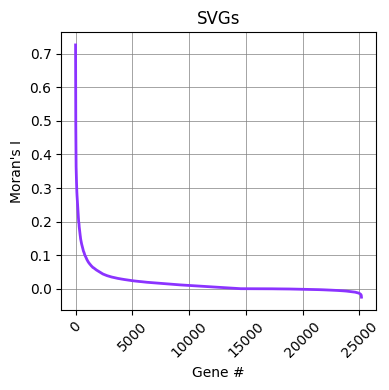

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(list(nh_df_sorted['KNN 6']), linewidth=2, color='#8b33ff')
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Moran's I")
ax.set_xlabel('Gene #')
ax.set_title(f'SVGs')
plt.tight_layout()
plt.show()

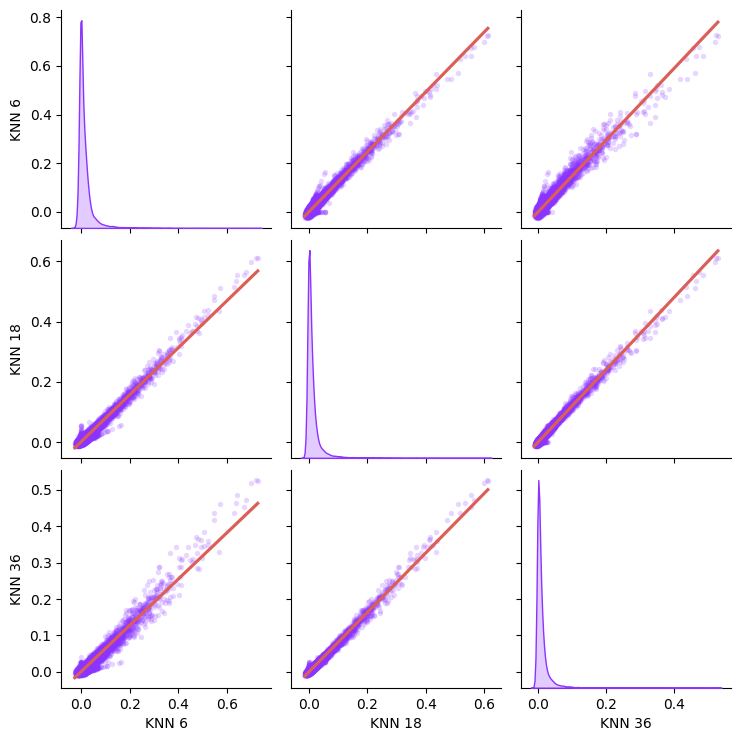

In [9]:
g = sns.pairplot(nh_df_sorted[['KNN 6', 'KNN 18', 'KNN 36']], diag_kind="kde", kind="reg",
             plot_kws={'scatter_kws': {'marker':".", 'linewidth':0, 'alpha':0.2, 'color':['#8b33ff'], 's':15},
                       'line_kws': {'color': '#db5f57'}},
             diag_kws=dict(color='#8b33ff'))
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_rasterized(True)
    for coll in ax.collections:
        coll.set_rasterized(True)
plt.show()